In [6]:
import pyemu
import flopy as fp
from flopy.utils import Raster
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import sys

sys.path.append("../../modules")
# hand made functions
from Rouss import *

In [2]:
t_d ="master_glm" # folder where jacobian has been calculated
case = "2D_test"
pst = pyemu.Pst(os.path.join(t_d,"{}.pst".format(case)))
pst.write_par_summary_table(filename="none")

,type,transform,count,initial value,upper bound,lower bound,standard deviation
cond,cond,log,6,-2.30103,-2,-3,0.25
irr__multiplier,irr__multiplier,log,14,0,0.30103,-0.09691,0.099485
kp_inst:0,kp_inst:0,log,147,-0.244888 to 1.09342,2,-1.30103,0.825257


[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

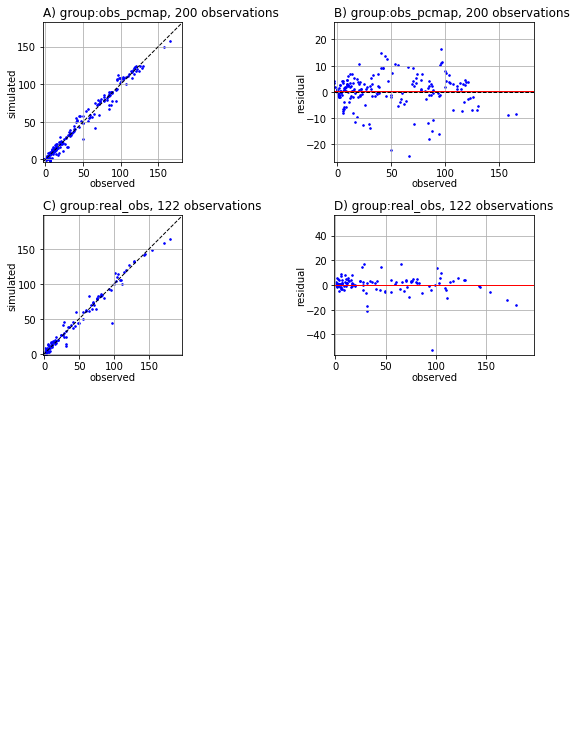

In [3]:
pst.plot(kind='1to1')

In [4]:
pst.control_data.noptmax = 6 # number of iterations (should be set to a great value (50))
pst.control_data.nphistp = 6
pst.pestpp_options["n_iter_base"] = -1
pst.pestpp_options["n_iter_super"] = 4
pst.pestpp_options["glm_num_reals"] = 50 # how many draws
pst.pestpp_options["parcov"] = "{}.prior.cov".format(case)
pst.pestpp_options["base_jacobian"] = "{}.jcb".format(case)
pst.write(os.path.join(t_d,"{}.pst".format(case)))

noptmax:6, npar_adj:167, nnz_obs:322


In [5]:
# DO the inversion
m_d = "master_glm_run"
pyemu.os_utils.start_workers(t_d,"../../pestpp-glm.exe","{}.pst".format(case),num_workers=10,worker_root=".",
                             master_dir=m_d)

[<Figure size 576x756 with 0 Axes>, <Figure size 576x756 with 8 Axes>]

<Figure size 576x756 with 0 Axes>

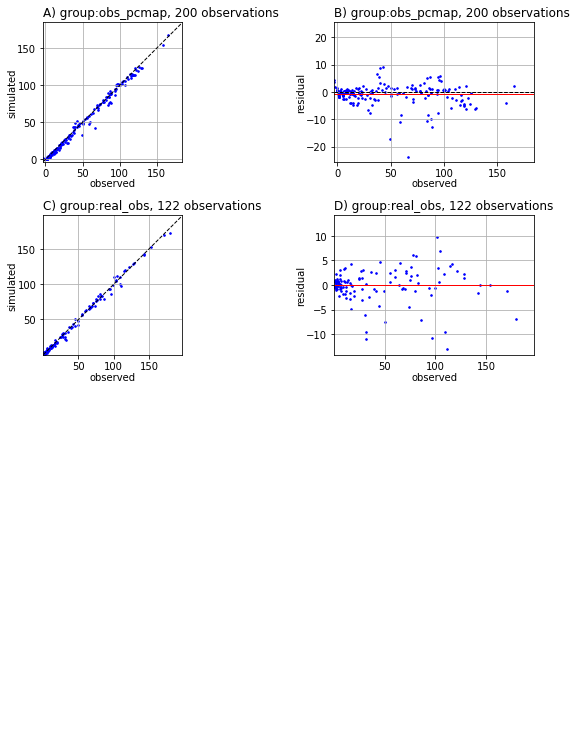

In [47]:
m_d = "master_glm_run"
pst_2 = pyemu.Pst(os.path.join(m_d,"{}.pst".format(case)))
pst_2.plot(kind="1to1")

4204.2180153656645 {'obs_pcmap': 2806.4509849624574, 'real_obs': 1397.7670304032074} {'obs_pcmap': 0.6675322199527668, 'real_obs': 0.33246778004723326}


[None,
 None,

<Figure size 576x756 with 0 Axes>

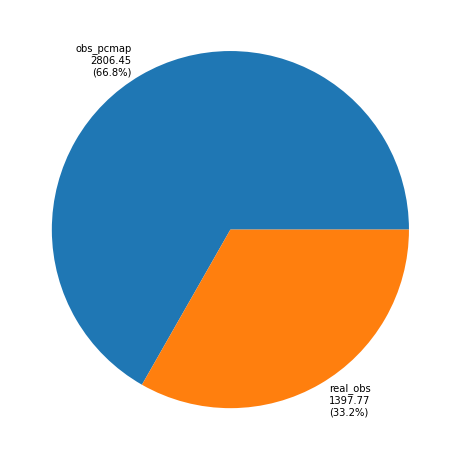

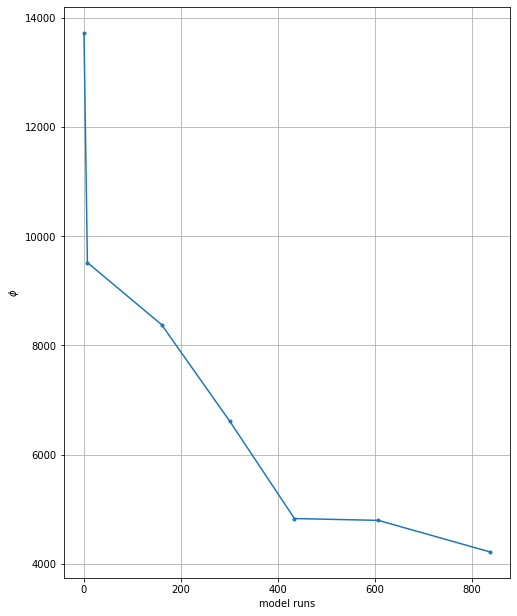

In [48]:
pst_2.plot()

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pyemu\en.py:365: UserWarning: Ensemble.from_dataframe() is deprecated and has been replaced with the standard constructor, which takesthe same arguments
  warnings.warn("Ensemble.from_dataframe() is deprecated and has been "


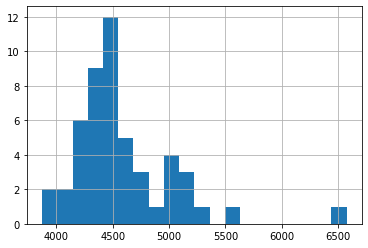

In [49]:
df = df=pd.read_csv(os.path.join(m_d,"{}.post.obsen.csv".format(case)),index_col=0)
oe = pyemu.ObservationEnsemble.from_dataframe(pst=pst,df=df)

ax = oe.phi_vector.hist(bins=20)

In [50]:
dfp = df=pd.read_csv(os.path.join(m_d,"{}.par.usum.csv".format(case)),index_col=0)
dfp.head()

,prior_mean,prior_stdev,prior_lower_bound,prior_upper_bound,post_mean,post_stdev,post_lower_bound,post_upper_bound
name,,,,,,,,
KP_INST:0_I:4_J:139,0.0,0.347959,-0.695918,0.695918,-0.338597,0.347787,-1.034170,0.356977
KP_INST:0_I:13_J:139,0.0,0.347959,-0.695918,0.695918,0.071678,0.347294,-0.622910,0.766267
KP_INST:0_I:22_J:130,0.0,0.347959,-0.695918,0.695918,0.368199,0.343577,-0.318955,1.055350
KP_INST:0_I:22_J:139,0.0,0.347959,-0.695918,0.695918,-1.301030,0.345889,-1.992810,-0.609252
KP_INST:0_I:31_J:121,0.0,0.347959,-0.695918,0.695918,-1.301030,0.329452,-1.959930,-0.642126


[Text(0.5, 1.0, 'Post standard deviation distribution (multiplier)')]

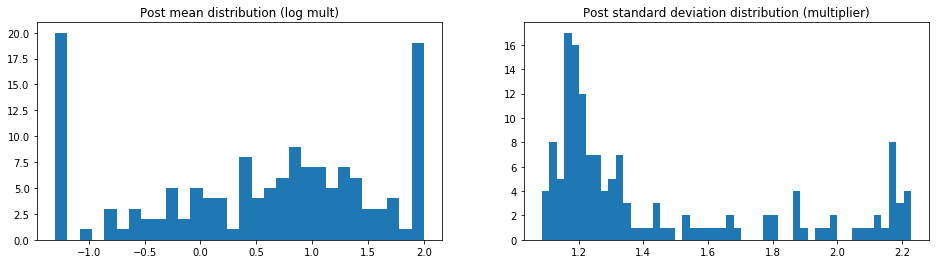

In [51]:
idx = [i for i in dfp.index if "KP" in i]
fig,ax=plt.subplots(1,2,figsize=(16,4))

ax[0].hist(dfp.loc[idx]["post_mean"],bins=30)
ax[0].set(title="Post mean distribution (log mult)")
ax[1].hist(10**dfp.loc[idx]["post_stdev"],bins=50)
ax[1].set(title="Post standard deviation distribution (multiplier)")

In [52]:
pst_2.parameter_data.parval1.iloc[:147]

parnme
kp_inst:0_i:4_j:139       1.00
kp_inst:0_i:13_j:139      1.00
kp_inst:0_i:22_j:130      1.00
kp_inst:0_i:22_j:139      1.00
kp_inst:0_i:31_j:121      1.00
                         ...  
kp_inst:0_i:157_j:139     1.00
kp_inst:0_i:166_j:58     12.40
kp_inst:0_i:166_j:103     2.12
kp_inst:0_i:175_j:49      6.65
kp_inst:0_i:175_j:58     12.40
Name: parval1, Length: 147, dtype: float64

In [53]:
npp=147

#kriging standard dev
pst_2.control_data.noptmax = 0 # number of iterations (should be set to a great value (50))
pst_2.parameter_data.parval1.iloc[:npp] = 10**dfp["post_stdev"].values[:npp]
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kstd = np.loadtxt(os.path.join(t_d,"k.txt"))
kstd[kstd == kstd[0,0]] = None

#kriging prior stdv
pst_2.parameter_data.parval1.iloc[:npp] = 10**dfp["prior_stdev"].values[:npp]
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kstdprio = np.loadtxt(os.path.join(t_d,"k.txt"))
kstdprio[np.isnan(kstd)] = None

#kriging kmax
pst_2.parameter_data.parval1 = 10**dfp["post_upper_bound"].values
pst_2.control_data.noptmax = 0 # one run
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kmax = np.loadtxt(os.path.join(t_d,"k.txt"))
kmax[np.isnan(kstd)] = None

#kriging kmin
pst_2.parameter_data.parval1 = 10**dfp["post_lower_bound"].values
pst_2.control_data.noptmax = 0 # one run
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)
kmin = np.loadtxt(os.path.join(t_d,"k.txt"))
kmin[np.isnan(kstd)] = None

#kriging k to plot
pst_2.parameter_data.parval1 = 10**dfp["post_mean"].values
pst_2.control_data.noptmax = 0 # one run
pst_2.write(os.path.join(t_d,"{}.pst".format(case)))
pyemu.os_utils.run("..\..\pestpp-glm.exe {}".format(case),cwd=t_d)

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


noptmax:0, npar_adj:167, nnz_obs:322
noptmax:0, npar_adj:167, nnz_obs:322
noptmax:0, npar_adj:167, nnz_obs:322
noptmax:0, npar_adj:167, nnz_obs:322
noptmax:0, npar_adj:167, nnz_obs:322


[Text(0.5, 1.0, 'Ratio post kstd vs prior kstd')]

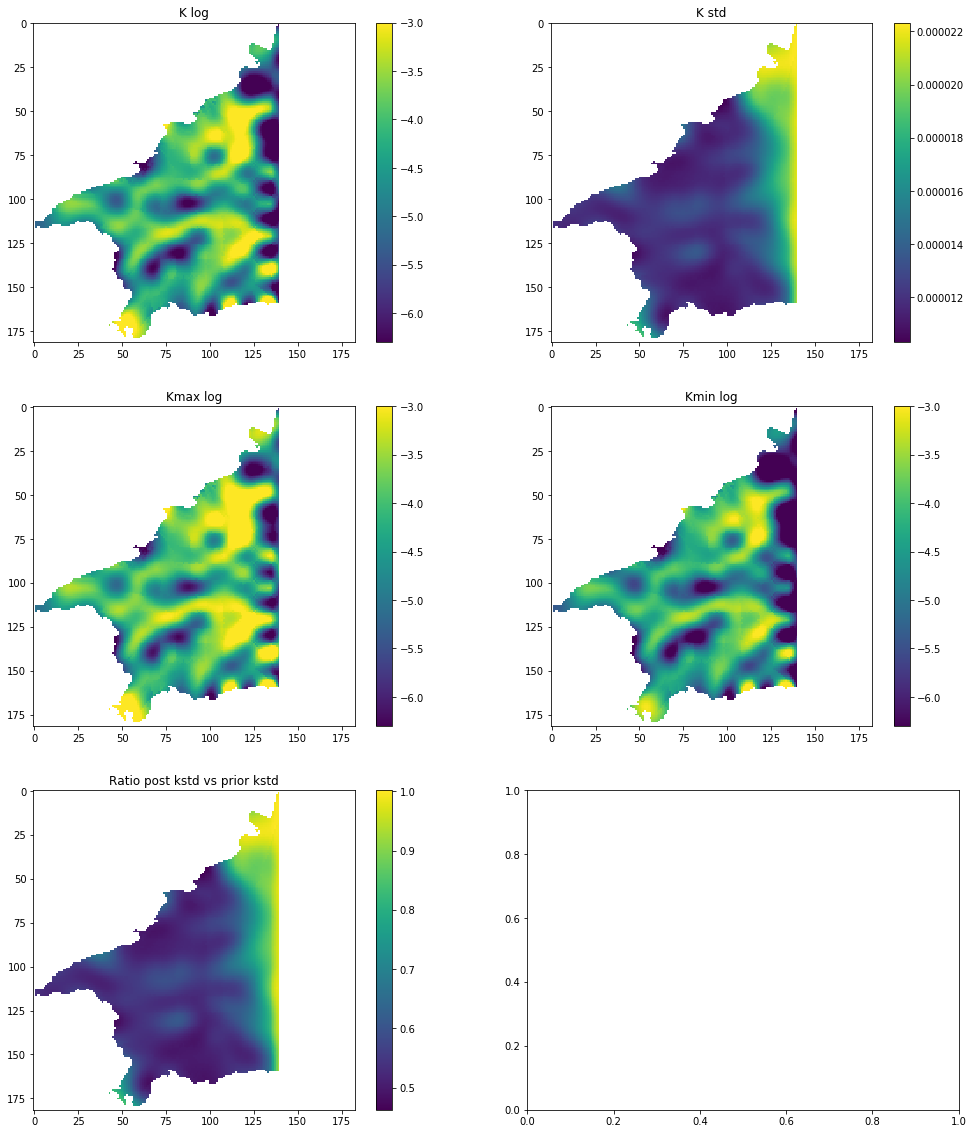

In [71]:
# inversion
fig,ax = plt.subplots(3,2,figsize=(17,20))
a1 = ax[0,0].imshow(k)
fig.colorbar(a1,ax=ax[0,0])
ax[0,0].set(title="K log")

a2 = ax[0,1].imshow((kstd))
fig.colorbar(a2,ax=ax[0,1])
ax[0,1].set(title="K std")

a3 = ax[1,0].imshow(np.log10(kmax))
fig.colorbar(a3,ax=ax[1,0])
ax[1,0].set(title="Kmax log")

a4 = ax[1,1].imshow(np.log10(kmin))
fig.colorbar(a4,ax=ax[1,1])
ax[1,1].set(title="Kmin log")

a5 = ax[2,0].imshow(kstd/kstdprio)
fig.colorbar(a5,ax=ax[2,0])
ax[2,0].set(title="Ratio post kstd vs prior kstd")

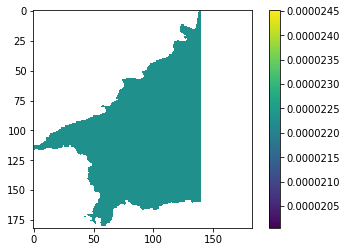

In [64]:
plt.imshow(kstdprio)
plt.colorbar()

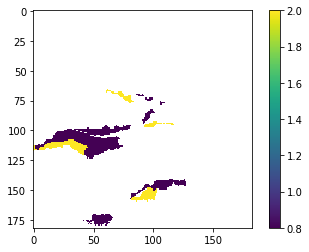

In [19]:
plt.imshow((np.loadtxt(os.path.join(t_d,"irr.txt")))/np.loadtxt(os.path.join("workspace","irr.txt")))
plt.colorbar()

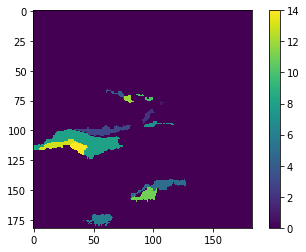

In [16]:
plt.imshow((np.loadtxt(os.path.join(t_d,"zone_irr.txt"))))
plt.colorbar()

In [74]:
m_n_i = "pest_2d_r"
m_n = "PEST_2D_R"
sim = fp.mf6.MFSimulation.load(sim_ws="workspace")
m = sim.get_model(m_n_i)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package obs...
    loading package npf...
    loading package rch...
    loading package rch...
    loading package rch...
    loading package wel...
    loading package wel...
    loading package chd...
    loading package chd...
    loading package drn...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
    loading package riv...
  loading ims package pest_2d_r...


In [75]:
grid = m.modelgrid
pz="../../data/cartes_pz/Piézo_Pliocène_1990_V2.grd"
rast = Raster.load(pz)
Mes_pz = rast.resample_to_grid(grid.xcellcenters,grid.ycellcenters,1)

In [76]:
rivfiles = [os.path.splitext(riv)[0] for riv in os.listdir("workspace") if riv.endswith(".riv")]

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  app.launch_new_instance()


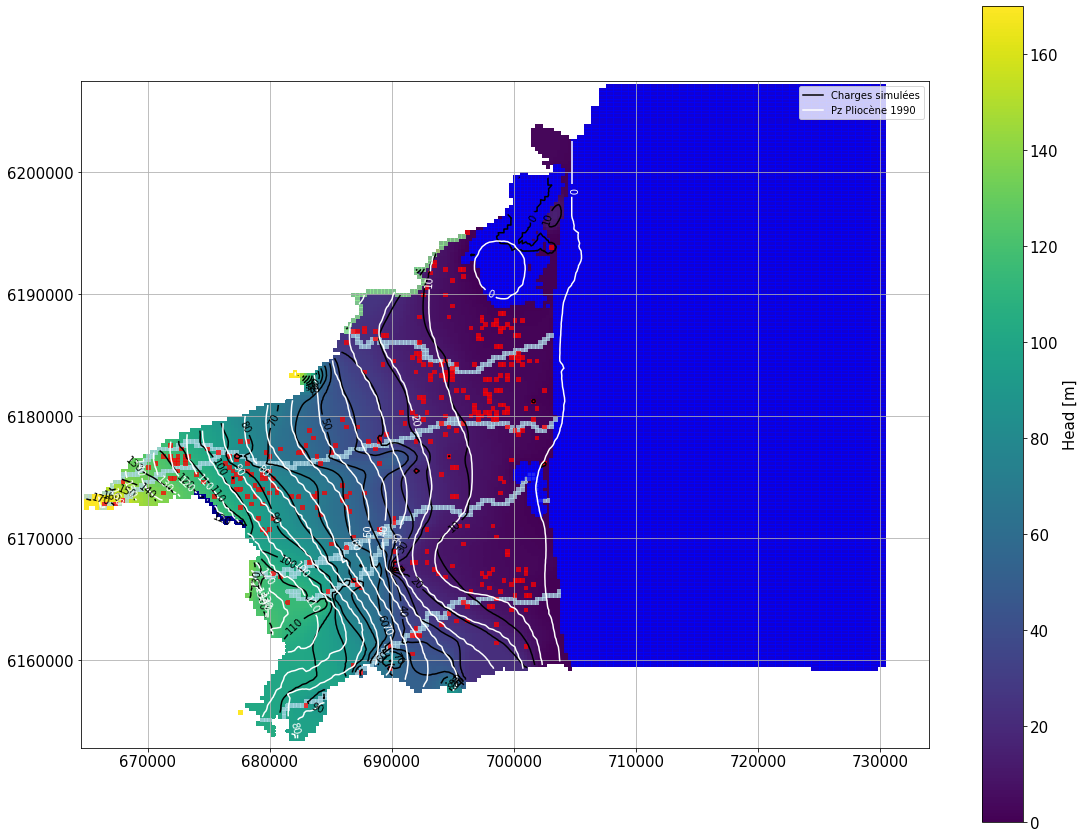

In [77]:
head = get_heads("pest_2D_R",t_d)

# initialize plot
fig = plt.figure(figsize=(19,15))
layer = 0
ax  = plt.subplot(1, 1,1, aspect='equal')
ml = fp.plot.PlotMapView(model=m,layer=layer)

#plot heads
hmesh = ml.plot_array(head[layer],masked_values=[0,1e30],cmap="viridis")
hmesh.set_clim(0,170)
cont = ml.contour_array(head[layer],masked_values=[0,1e30],levels=np.linspace(0,170,18),colors='black')
plt.clabel(cont,fmt="%1i")

##cont des mesures piézométriques
Mes_pz[[head[layer]==1e30]]=None
cont_2=ml.contour_array(Mes_pz,levels=np.linspace(0,170,18),colors='white')
plt.clabel(cont_2,fmt="%1i")

#legend
proxy = [plt.Line2D((0,1),(0,0),color="black"),plt.Line2D((0,1),(0,0),color="white")]
plt.legend(proxy,["Charges simulées","Pz Pliocène 1990"])

# plot bc
ml.plot_bc("sea",color="b",alpha=0.5)
for riv in rivfiles:
    ml.plot_bc(riv,color="lightblue",alpha=0.5)
ml.plot_bc("eta",color="b",alpha=0.5)
ml.plot_bc("wel",alpha=0.5)
ml.plot_bc("Corb",color="lightgreen",alpha=0.5)
ml.plot_bc("thuir",color="darkblue",alpha=1)

ax.tick_params(labelsize=15)

#colorbar
g = plt.colorbar(hmesh)
g.set_label("Head [m]",fontsize=15)
g.ax.tick_params(labelsize=15)

ax.grid()

C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\Users\schorppl\AppData\Local\Continuum\anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


MAE : 2.206792737158603 m 
RMSE : 3.3574180164411933
phi : 1397.7597114033654


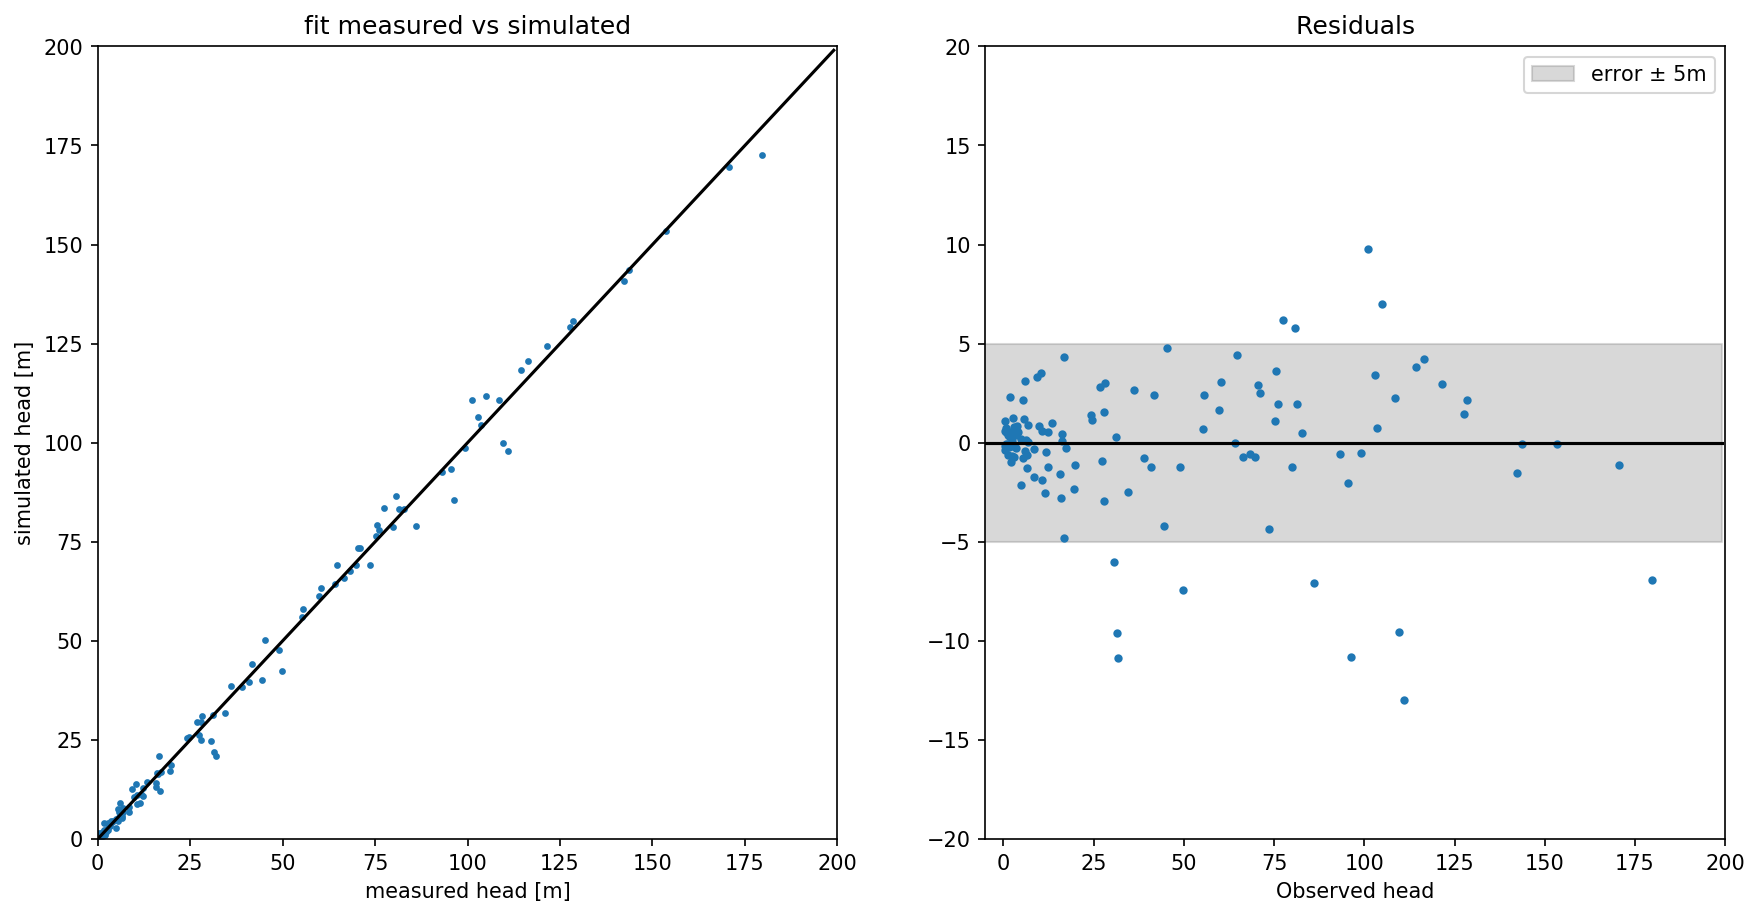

In [79]:
## plot errors and residuals

# control piezos
piez_path="../../data/piezos/pz_hydriad.xlsx"
#import the data using this function (path,modelgrid, sheetname of the data,piezometric level column, x and y coor (in L93 !))
Control_pz = importControlPz(piez_path,grid,sheetName="2012",np_col="NP_Avril2013",x_col="x",y_col="y")

# retrieve heads and spdis 
fig,ax = plt.subplots(1,2,figsize=(14,7),dpi=150)

head = get_heads(m_n,t_d)
head[head>1000]=None
i=0
ax[i].scatter(Control_pz[Control_pz!=0],
            head[0][Control_pz!=0],s=5)
ax[i].plot(np.arange(-10,200),np.arange(-10,200),"k")
ax[i].set(xlabel="measured head [m]",ylabel="simulated head [m]",title="fit measured vs simulated",
         xlim=(0,200),ylim=(0,200))

i=1
ax[i].plot(Control_pz[Control_pz!=0],head[0][Control_pz!=0]-Control_pz[Control_pz!=0],".")

xfit = np.arange(-10,200)
yfit = np.zeros([210])
dyfit = 5
ax[i].fill_between(xfit, yfit - dyfit, yfit + dyfit,
                 color='gray', alpha=0.3,label="error ± 5m")
ax[i].plot(xfit,yfit,"k")
ax[i].set(xlim=(-5,200),ylim=(-20,20),title="Residuals",xlabel="Observed head")
plt.legend()

Misfit = np.abs((Control_pz[Control_pz!=0] - head[0][Control_pz!=0]))
print("MAE : {} m ".format(np.nanmean(Misfit)))
Misfit2 = (np.nansum((((Control_pz[Control_pz!=0] - head[0][Control_pz!=0])**2)/Control_pz[Control_pz!=0].shape[0])))**0.5
print("RMSE : {}".format(Misfit2))
phi = np.nansum((Control_pz[Control_pz!=0] - head[0][Control_pz!=0])**2)
print("phi : {}".format(phi))